In [3]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt


In [5]:
# Load YOLOv3 weights and config
config_path = "yolov3.cfg"
weights_path = "yolov3.weights"
names_path = "coco.names"

# Load class labels
with open(names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the YOLOv3 model using OpenCV
net = cv2.dnn.readNet(weights_path, config_path)

# Get layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


In [17]:
# Load an image
image_path = "baggage_claim.jpg"  # Change this to your image path
image = cv2.imread(image_path)
height, width, channels = image.shape

# Convert image to blob format
blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
net.setInput(blob)


In [19]:
# Forward pass through YOLO
start_time = time.time()
outputs = net.forward(output_layers)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")


Time taken: 0.26 seconds


In [21]:
# Initialize lists
boxes = []
confidences = []
class_ids = []

# Confidence threshold
conf_threshold = 0.5
nms_threshold = 0.4

# Process each detection
for output in outputs:
    for detection in output:
        scores = detection[5:]  # Skip first 5 values (box coordinates)
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
        if confidence > conf_threshold:
            # Scale bounding box coordinates
            center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype(int)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply Non-Maximum Suppression (NMS)
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)


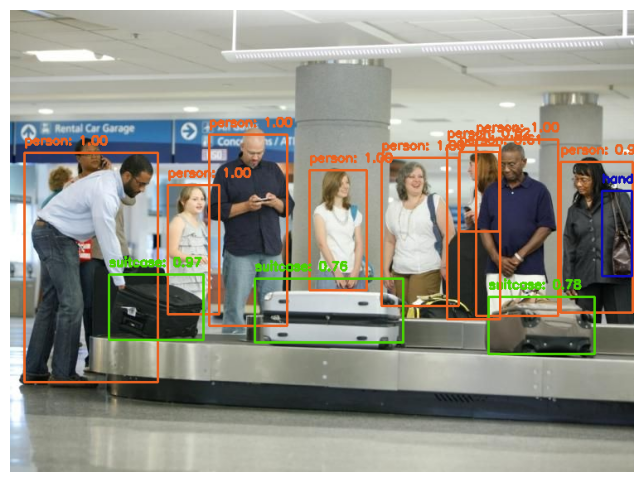

In [23]:
# Define colors
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Check if any boxes are detected
if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = colors[class_ids[i]]
        
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Convert BGR to RGB for Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
